# Mole image classifier
#### Using Tensroflow 2.0 and Keras



In [0]:
!pip install -q kaggle
!pip install tensorflow==2.0.0

#### Download Skin Cancer MNIST: HAM10000 dataset from Kaggle

Instructions for kaggle API here: https://github.com/Kaggle/kaggle-api

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000
!unzip skin-cancer-mnist-ham10000.zip

In [0]:
import os
import random
import pandas as pd
import numpy as np
from shutil import copyfile, move

from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

In [58]:
tf.__version__

'2.0.0'

#### Brifely explore dataset

In [59]:
metadata = pd.read_csv('HAM10000_metadata.csv')
metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


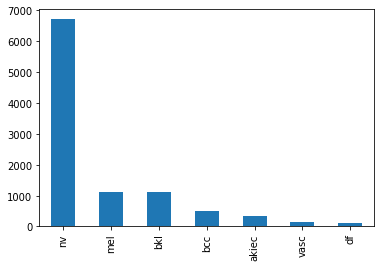

In [60]:
metadata['dx'].value_counts().plot(kind='bar')

Cases include a representative collection of all important diagnostic categories in the realm of pigmented lesions: Actinic keratoses and intraepithelial carcinoma / Bowen's disease (akiec), basal cell carcinoma (bcc), benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses, bkl), dermatofibroma (df), melanoma (mel), melanocytic nevi (nv) and vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, vasc).

More than 50% of lesions are confirmed through histopathology (histo), the ground truth for the rest of the cases is either follow-up examination (followup), expert consensus (consensus), or confirmation by in-vivo confocal microscopy (confocal). The dataset includes lesions with multiple images, which can be tracked by the lesionid-column within the HAM10000_metadata file.

#### Organise images into train, valid and test folders

In [0]:
lesion_types = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

In [0]:
# create folders for train, validation and test sets
os.mkdir('data')

for dataset in ['train', 'valid', 'test']:
  os.mkdir(f'data/{dataset}')
  for lesion_type in lesion_types:
    os.mkdir(f'data/{dataset}/{lesion_type}')

In [0]:
# move all images to relevant train folder
for index, row in metadata.iterrows():
  try:
    src = f'HAM10000_images_part_1/{row["image_id"]}.jpg'
    dst = f'data/train/{row["dx"]}/{row["image_id"]}.jpg'
    copyfile(src, dst)
  except FileNotFoundError:
    src = f'HAM10000_images_part_2/{row["image_id"]}.jpg'
    dst = f'data/train/{row["dx"]}/{row["image_id"]}.jpg'
    copyfile(src, dst)

In [16]:
# sample valid (10%) and test (10%) sets
for lesion in lesion_types:
  train_path = f'data/train/{lesion}/'
  valid_path = f'data/valid/{lesion}/'
  test_path = f'data/test/{lesion}/'

  print(f'Creating {lesion} valid and test dataset...')

  files = os.listdir(train_path)
  num_files = len(files)

  print(f'Number of images for lesion: {num_files}')

  portion = 0.1
  k = int(num_files * portion)

  file_array = np.array(files)
  np.random.shuffle(file_array)
  valid_files = file_array[0:k]
  test_files = file_array[k+1:2*k]

  for f in valid_files:
    move(train_path + f, valid_path)
  
  for f in test_files:
    move(train_path + f, test_path)

Creating akiec valid and test dataset...
Number of images for lesion: 327
Creating bcc valid and test dataset...
Number of images for lesion: 514
Creating bkl valid and test dataset...
Number of images for lesion: 1099
Creating df valid and test dataset...
Number of images for lesion: 115
Creating mel valid and test dataset...
Number of images for lesion: 1113
Creating nv valid and test dataset...
Number of images for lesion: 6705
Creating vasc valid and test dataset...
Number of images for lesion: 142


In [0]:
# remove unused folders
!rm -rf HAM10000_images_part_1/
!rm -rf HAM10000_images_part_2/
!rm -rf ham10000_images_part_1/
!rm -rf ham10000_images_part_2/
!rm -rf sample_data/
!rm hmnist_28_28_L.csv
!rm hmnist_28_28_RGB.csv
!rm hmnist_8_8_RGB.csv
!rm hmnist_8_8_L.csv
!rm skin-cancer-mnist-ham10000.zip

#### Inspect created train, valid and test sets

In [0]:
PATH = 'data'
train_dir = os.path.join(PATH, 'train')
valid_dir = os.path.join(PATH, 'valid')
test_dir = os.path.join(PATH, 'test')

train_dirs = {}
valid_dirs = {}
test_dirs = {}
for lesion in lesion_types:
  train_dirs[lesion] = os.path.join(train_dir, lesion)
  valid_dirs[lesion] = os.path.join(valid_dir, lesion)
  test_dirs[lesion] = os.path.join(test_dir, lesion)

In [0]:
num_tr = {}
num_val = {}
num_test = {}
for lesion in lesion_types:
  num_tr[lesion] = len(os.listdir(train_dirs[lesion]))
  num_val[lesion] = len(os.listdir(valid_dirs[lesion]))
  num_test[lesion] = len(os.listdir(test_dirs[lesion]))

total_train = sum(num_tr.values())
total_val = sum(num_val.values())
total_test = sum(num_test.values())

In [82]:
for lesion in lesion_types: 
  print(f'total training {lesion} images:', num_tr[lesion])
  print(f'total validation {lesion} images:', num_val[lesion])
  print(f'total test {lesion} images:', num_test[lesion])
  print('---')

print('---')
print("Total training images:", total_train)
print("Total validation images:", total_val)
print("Total test images:", total_test)

total training akiec images: 264
total validation akiec images: 32
total test akiec images: 31
---
total training bcc images: 413
total validation bcc images: 51
total test bcc images: 50
---
total training bkl images: 882
total validation bkl images: 109
total test bkl images: 108
---
total training df images: 94
total validation df images: 11
total test df images: 10
---
total training mel images: 892
total validation mel images: 111
total test mel images: 110
---
total training nv images: 5366
total validation nv images: 670
total test nv images: 669
---
total training vasc images: 115
total validation vasc images: 14
total test vasc images: 13
---
---
Total training images: 8026
Total validation images: 998
Total test images: 991


#### Prepare images using ImageGenerator from Keras

In [0]:
batch_size = 128
epochs = 5
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [0]:
train_image_generator = ImageDataGenerator(
                            rescale=1./255,
                            rotation_range=45,
                            width_shift_range=.15,
                            height_shift_range=.15,
                            horizontal_flip=True,
                            zoom_range=0.5)
validation_image_generator = ImageDataGenerator(rescale=1./255)

In [66]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='categorical',
                                                           classes=lesion_types)

Found 8026 images belonging to 7 classes.


In [67]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=valid_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='categorical',
                                                              classes=lesion_types)

Found 998 images belonging to 7 classes.


In [0]:
sample_training_images, _ = next(train_data_gen)

In [0]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

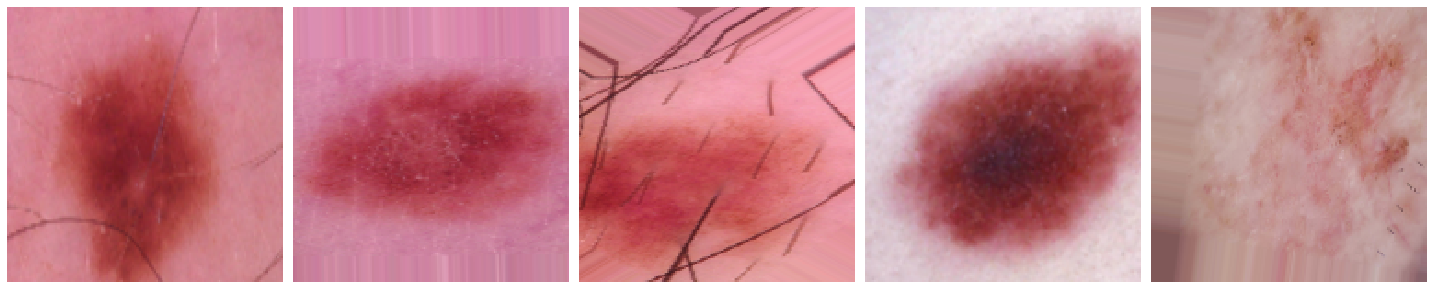

In [70]:
plotImages(sample_training_images[:5])

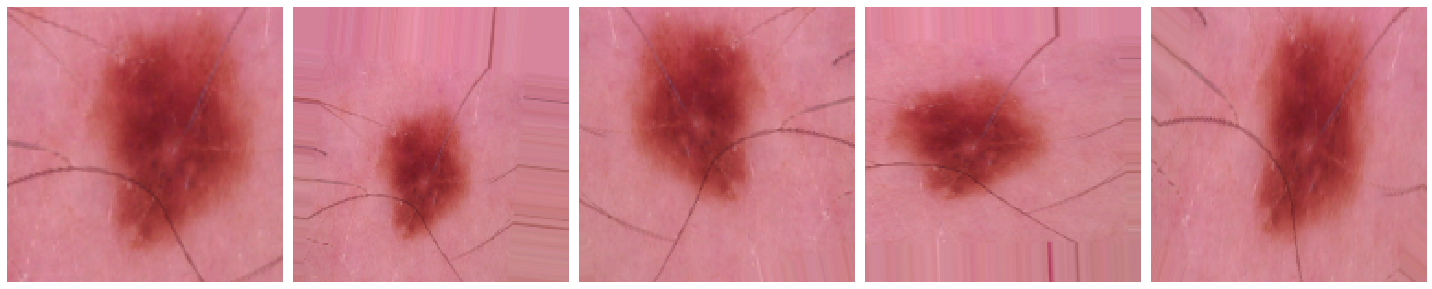

In [71]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

#### Build Sequential model

In [0]:
model_new = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', 
           input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(7)
])

In [0]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [74]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 20736)            

#### Train and evaluate model

In [77]:
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Epoch 1/5
62/62 [==============================] - 304s 5s/step - loss: 0.7781 - accuracy: 0.7152 - val_loss: 0.6100 - val_accuracy: 0.7746
Epoch 2/5
62/62 [==============================] - 306s 5s/step - loss: 0.7334 - accuracy: 0.7273 - val_loss: 0.6079 - val_accuracy: 0.7556
Epoch 3/5
62/62 [==============================] - 302s 5s/step - loss: 0.6946 - accuracy: 0.7431 - val_loss: 0.6117 - val_accuracy: 0.7679
Epoch 4/5
62/62 [==============================] - 305s 5s/step - loss: 0.6886 - accuracy: 0.7442 - val_loss: 0.6319 - val_accuracy: 0.7600
Epoch 5/5
62/62 [==============================] - 302s 5s/step - loss: 0.6704 - accuracy: 0.7472 - val_loss: 0.5789 - val_accuracy: 0.7835


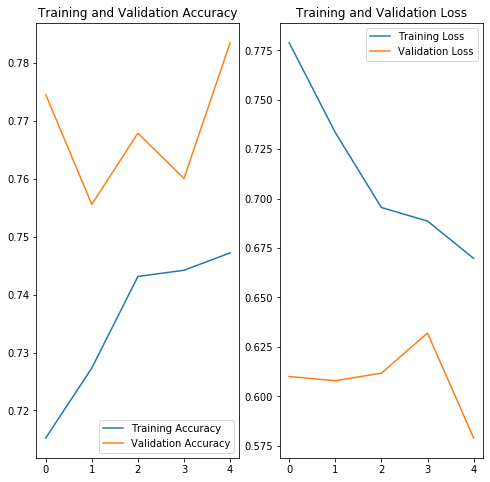

In [78]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Evaluate and make predcitions on test set

In [83]:
test_image_generator = ImageDataGenerator(rescale=1./255)

test_data_gen = test_image_generator.flow_from_directory(batch_size=1,
                                                         directory=test_dir,
                                                         target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                         class_mode='categorical',
                                                         classes=lesion_types)

Found 991 images belonging to 7 classes.


In [117]:
evaluation = model.evaluate_generator(test_data_gen, 
                                      steps=total_test)

val_data_gen.reset()
prediction = model.predict_generator(test_data_gen, 
                                     steps=total_test)

print(f'Test loss: {evaluation[0]}')
print(f'Test accuracy: {evaluation[1]}')

Test loss: 0.6548710044668913
Test accuracy: 0.7547931671142578


In [116]:
print('Classification Report - Test set')
print(classification_report(test_data_gen.classes, predicted_class_indices, target_names=lesion_types))

Classification Report - Validation set
              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        31
         bcc       0.00      0.00      0.00        50
         bkl       0.12      0.11      0.11       108
          df       0.00      0.00      0.00        10
         mel       0.07      0.05      0.05       110
          nv       0.66      0.72      0.69       669
        vasc       0.00      0.00      0.00        13

    accuracy                           0.51       991
   macro avg       0.12      0.13      0.12       991
weighted avg       0.46      0.51      0.48       991



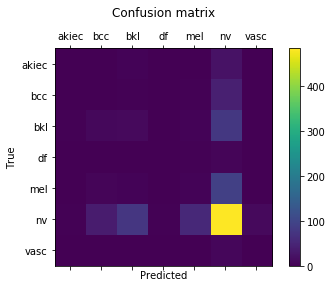

In [113]:
predicted_class_indices = np.argmax(prediction, axis=1)

labels = (train_data_gen.class_indices)
labels = dict((v,k) for k,v in labels.items())

predictions = [labels[k] for k in predicted_class_indices]

filenames = test_data_gen.filenames
results = pd.DataFrame({"true": [filename.split('/')[0] for filename in filenames],
                        "pred": predictions})

cm = confusion_matrix(results['true'], results['pred'], lesion_types)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix\n')
fig.colorbar(cax)
ax.set_xticklabels([''] + lesion_types)
ax.set_yticklabels([''] + lesion_types)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()